## Analysis

In this notebook, the assortativity, or homophily (based on the locality label) of the Harvey and Florence networks are established and tested for significance.

In [69]:
import os
from tex_funcs import set_tex_var as set_tex_var_import
from tex_funcs import df_to_tex as df_to_tex_import
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 28})

LATEX_DIR = './data/harvey_user_location/latex/'
LATEX_DAT_PATH = './data/harvey_user_location/latex/network-analysis.dat'
LATEX_TABLE_PATH = './data/harvey_user_location/latex/network-analysis-tabs.dat'

def set_tex_var(name, val, dec=3):
    set_tex_var_import(name, val, LATEX_DAT_PATH, dec)

def df_to_tex(df, cols=None, label='UNNAMED', caption='UNDEFINED', 
    width=0.8, row_sep=1, col_widths=None, dec_dict=None,sum_row=False):
    df_to_tex_import(df, LATEX_TABLE_PATH, cols, label, caption, width, row_sep, col_widths, dec_dict,sum_row)

In [18]:
# Only run if processing entire notebook:

# for file in [LATEX_DAT_PATH, LATEX_TABLE_PATH]:
#     try:    
#         os.remove(file)
#     except:
#         pass

In [5]:
DIR = './data/harvey_user_location/'
with open(DIR + 'locality_dict_hrv.txt') as json_file:
    hrv_locs = json.load(json_file)
print('Unique Harvey Locs:', len(hrv_locs))

DIR = './data/florence_user_location/'
with open(DIR + 'flr_locs.txt') as json_file:
    flr_locs = json.load(json_file)
print('Unique Florence Locs:', len(flr_locs))

Unique Harvey Locs: 5056
Unique Florence Locs: 29507


In [6]:
set_tex_var('hrvUniqLocs', len(hrv_locs))
set_tex_var('flrUniqLocs', len(flr_locs))

### Harvey Network

In [66]:
import networkx as nx

DIR = './data/harvey_user_location/graph_objs/'
GEXF_FILE = 'network_data_HurricaneHarvey_v1.gexf'
G = nx.read_gexf(DIR + GEXF_FILE)
# Make undirected:
G2 = nx.Graph(G)

In [67]:
Gcc = max(nx.connected_components(G2), key=len)
G_lcc = G2.subgraph(Gcc)

lcc_nodes = '{:,.0f} ({:.2f})'.format(G_lcc.number_of_nodes(), G_lcc.number_of_nodes()/G.number_of_nodes())
lcc_edges = '{:,.0f} ({:.2f})'.format(G_lcc.number_of_edges(), G_lcc.number_of_edges()/G.number_of_edges())

hrv_g_row = {'Event':'Harvey', 'Nodes':'{:,.0f}'.format(G.number_of_nodes()), 'Edges':'{:,.0f}'.format(G.number_of_edges())}
hrv_lcc_row = {'Event':'Harvey$_{LCC}$', 'Nodes':lcc_nodes, 'Edges':lcc_edges}

Gcc = None
G_lcc = None

In [68]:
assort_coef = nx.attribute_assortativity_coefficient(G2, 'lcl_profile')
print('Harvey assortativity for undirected graph:', assort_coef)
assort_coef = nx.attribute_assortativity_coefficient(G, 'lcl_profile')
print('Harvey assortativity for directed graph:', assort_coef)

Harvey assortativity for undirected graph: 0.37909172708250594
Harvey assortativity for directed graph: 0.385031221987116


In [8]:
# Excluding non-geocoded nodes:
partition = [node for node, data in G2.nodes(data=True) if data.get('lcl_profile') != '']
G2 = G2.subgraph(partition)
print('{} nodes reduced to {}'.format(G.number_of_nodes(), G2.number_of_nodes()))

assort_coef_1 = nx.attribute_assortativity_coefficient(G2, 'lcl_profile')
print('Harvey assortativity for non-null profile location nodes, undirected:', assort_coef_1)

G3 = G.subgraph(partition)
assort_coef_2 = nx.attribute_assortativity_coefficient(G3, 'lcl_profile')
print('Harvey assortativity for non-null profile location nodes, directed:', assort_coef_2)

31932 nodes reduced to 21157
Harvey assortativity for non-null profile location nodes, undirected: 0.6165076429568769
Harvey assortativity for non-null profile location nodes, directed: 0.6265234987134032


In [9]:
set_tex_var('hrvAssortCoef', assort_coef_2, 3)

hrv_g_row = {'Event':'Harvey', 'Nodes':orig_nodes, 'Edges':orig_edges}
hrv_g2_row = {'Event':'Harvey$_{LCC}$', 'Nodes':G2.number_of_nodes(), 'Edges':G2.number_of_edges()}
hrv_assort_row = {'Event': 'Harvey', 'Nodes$_{total}$':orig_nodes, 'Nodes$_{filtered}$':G2.number_of_nodes(), 'Assortativity':assort_coef_2}

Assortativity based on the coded label is also calculated. This uses a subgraph of only nodes which have been coded.

In [10]:
G3 = G.copy()

nodes = [
    node
    for node, data
    in G3.nodes(data=True)
    if data.get("user_code") != ""
]
G3 = G3.subgraph(nodes)

attrs = {}
for node, data in G3.nodes(data=True):
    if data.get("user_code") != "Non-Witness":
        attrs[node] = {"user_code":True}
    else:
        attrs[node] = {"user_code":False}
nx.set_node_attributes(G3, attrs)

assort_coef_1 = nx.attribute_assortativity_coefficient(G3, 'user_code')
print('Harvey coded dataset assortativity, directed:', assort_coef)
assort_coef_2 = nx.attribute_assortativity_coefficient(nx.Graph(G3), 'user_code')
print('Harvey coded dataset assortativity, undirected:', assort_coef)


# Check LCC (of full graph)
Gcc = max(nx.connected_components(G2), key=len)
G4 = G3.subgraph(Gcc)

assort_coef_3 = nx.attribute_assortativity_coefficient(G4, 'user_code')
print('Harvey LCC coded dataset assortativity, directed:', assort_coef)
assort_coef_4 = nx.attribute_assortativity_coefficient(nx.Graph(G4), 'user_code')
print('Harvey LCC coded dataset assortativity, undirected:', assort_coef)

Harvey coded dataset assortativity, directed: 0.385031221987116
Harvey coded dataset assortativity, undirected: 0.385031221987116
Harvey LCC coded dataset assortativity, directed: 0.385031221987116
Harvey LCC coded dataset assortativity, undirected: 0.385031221987116


In [11]:
val = assort_coef_1

set_tex_var('hrvAssortCoefCoded', val, 3)

if val >= 0.5:
    interp = 'strong'
elif val >= 0.3:
    interp = 'moderate'
elif val > 0:
    interp = 'low'
else:
    raise Exception('No correlation, check how value is used in document.')
set_tex_var('hrvAssortCoefCodedInterpretation', interp)

### Florence Network
Now the same calculations are repeated for the Florence dataset (excluding the coded subgraph)

In [1]:
import networkx as nx

DIR = './data/florence_user_location/'
# LCC of users detected within first week of event:
GEXF_FILE = 'Florence_network_data_20210721.gexf'
G = nx.read_gexf(DIR + GEXF_FILE)
# Make undirected:
G2 = nx.Graph(G)

In [23]:
########## NOTE: vals hardcoded as file is already the LCC subgraph.
orig_nodes = 124558
orig_edges = 3428659
##########

# Gcc = max(nx.connected_components(G2), key=len)
# G_lcc = G2.subgraph(Gcc)

# lcc_nodes = '{:,.0f} ({:.3f})'.format(G_lcc.number_of_nodes(), G_lcc.number_of_nodes()/G.number_of_nodes())
# lcc_edges = '{:,.0f} ({:.3f})'.format(G_lcc.number_of_edges(), G_lcc.number_of_edges()/G.number_of_edges())

lcc_nodes = '{:,.0f} ({:.2f})'.format(G.number_of_nodes(), G.number_of_nodes()/orig_nodes)
lcc_edges = '{:,.0f} ({:.2f})'.format(G.number_of_edges(), G.number_of_edges()/orig_edges)

flr_g_row = {'Event':'Florence', 'Nodes':'{:,.0f}'.format(orig_nodes), 'Edges':'{:,.0f}'.format(orig_edges)}
flr_lcc_row = {'Event':'Florence$_{LCC}$', 'Nodes':lcc_nodes, 'Edges':lcc_edges}

# Gcc = None
# G_lcc = None

In [ ]:
assort_coef = nx.attribute_assortativity_coefficient(G2, 'lcl_profile')
print('Florence assortativity for undirected graph:', assort_coef)
assort_coef = nx.attribute_assortativity_coefficient(G, 'lcl_profile')
print('Florence assortativity for directed graph:', assort_coef)

In [13]:
# Excluding non-geocoded nodes:
orig_nodes = G2.number_of_nodes()
partition = [node for node, data in G2.nodes(data=True) if data.get('lcl_profile') != None]
G2 = G2.subgraph(partition)
print('{} nodes reduced to {}'.format(orig_nodes, G2.number_of_nodes()))

assort_coef_1 = nx.attribute_assortativity_coefficient(G2, 'lcl_profile')
print('Florence assortativity for non-null profile location nodes, undirected:', assort_coef_1)

G3 = G.subgraph(partition)
assort_coef_2 = nx.attribute_assortativity_coefficient(G3, 'lcl_profile')
print('Florence assortativity for non-null profile location nodes, directed:', assort_coef_2)

106732 nodes reduced to 79807
Florence assortativity for non-null profile location nodes, undirected: 0.560285625242073
Florence assortativity for non-null profile location nodes, directed: 0.5417783804383417


In [14]:
set_tex_var('flrAssortCoef', assort_coef_2, 3)

flr_assort_row = {'Event': 'Florence', 'Nodes$_{total}$':orig_nodes, 'Nodes$_{filtered}$':G2.number_of_nodes(), 'Assortativity':assort_coef_2}

In [19]:
###########################
######### Florence network after exclusion box applied
###########################
import networkx as nx

DIR = './data/florence_user_location/'
# Network of users detected within first week of event:
GEXF_FILE = 'Florence_network_data_exclusion_20210729.gexf'
G = nx.read_gexf(DIR + GEXF_FILE)
# Make undirected:
G2 = nx.Graph(G)


# Gcc = max(nx.connected_components(G2), key=len)
# G_lcc = G2.subgraph(Gcc)

# lcc_nodes = '{:,.0f} ({:.2f})'.format(G_lcc.number_of_nodes(), G_lcc.number_of_nodes()/G.number_of_nodes())
# lcc_edges = '{:,.0f} ({:.2f})'.format(G_lcc.number_of_edges(), G_lcc.number_of_edges()/G.number_of_edges())

# flr_g_row = {'Event':'Florence', 'Nodes':'{:,.0f}'.format(G.number_of_nodes()), 'Edges':'{:,.0f}'.format(G.number_of_edges())}
# flr_lcc_row = {'Event':'Florence$_{LCC}$', 'Nodes':lcc_nodes, 'Edges':lcc_edges}

# Gcc = None
# G_lcc = None

assort_coef = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
print('Florence (exclusion) assortativity for undirected graph:', assort_coef)
assort_coef = nx.attribute_assortativity_coefficient(G, 'lcl_prf')
print('Florence (exclusion) assortativity for directed graph:', assort_coef)

# Excluding non-geocoded nodes:
orig_nodes = G2.number_of_nodes()
partition = [node for node, data in G2.nodes(data=True) if data.get('lcl_prf') != None]
G2 = G2.subgraph(partition)
print('{} nodes reduced to {}'.format(orig_nodes, G2.number_of_nodes()))

assort_coef_1 = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
print('Florence assortativity for non-null profile location nodes, undirected:', assort_coef_1)

G3 = G.subgraph(partition)
assort_coef_2 = nx.attribute_assortativity_coefficient(G3, 'lcl_prf')
print('Florence assortativity for non-null profile location nodes, directed:', assort_coef_2)

Florence (exclusion) assortativity for undirected graph: 0.2095158880510173
Florence (exclusion) assortativity for directed graph: 0.18983880059377306
100343 nodes reduced to 68897
Florence assortativity for non-null profile location nodes, undirected: 0.5364163672797281
Florence assortativity for non-null profile location nodes, directed: 0.5130369248901543


In [21]:
#Run again on LCC:
print(G.number_of_nodes(), G.number_of_edges())

G2 = nx.Graph(G)
Gcc = max(nx.connected_components(G2), key=len)
G2 = G2.subgraph(Gcc)
G = G.subgraph(Gcc)

print(G2.number_of_nodes(), G2.number_of_edges())

assort_coef = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
print('Florence (exclusion) assortativity for undirected graph:', assort_coef)
assort_coef = nx.attribute_assortativity_coefficient(G, 'lcl_prf')
print('Florence (exclusion) assortativity for directed graph:', assort_coef)

# Excluding non-geocoded nodes:
orig_nodes = G2.number_of_nodes()
partition = [node for node, data in G2.nodes(data=True) if data.get('lcl_prf') != None]
G2 = G2.subgraph(partition)
print('{} nodes reduced to {}'.format(orig_nodes, G2.number_of_nodes()))

assort_coef_1 = nx.attribute_assortativity_coefficient(G2, 'lcl_prf')
print('Florence assortativity for non-null profile location nodes, undirected:', assort_coef_1)

G3 = G.subgraph(partition)
assort_coef_2 = nx.attribute_assortativity_coefficient(G3, 'lcl_prf')
print('Florence assortativity for non-null profile location nodes, directed:', assort_coef_2)

100343 2523974
81274 1747636
Florence (exclusion) assortativity for undirected graph: 0.20943478414306793
Florence (exclusion) assortativity for directed graph: 0.18973403303935382
81274 nodes reduced to 60917
Florence assortativity for non-null profile location nodes, undirected: 0.5364150356059781
Florence assortativity for non-null profile location nodes, directed: 0.5130346105509414


In [ ]:
############################
import networkx as nx
DIR = './data/florence_user_location/'

GEXF_FILE = 'Florence_network_data_exclusion_wronglclprf_20210729.gexf'
G = nx.read_gexf(DIR + GEXF_FILE)
print(G.number_of_nodes(), G.number_of_edges())

GEXF_FILE = 'Florence_network_data_exclusion_20210729.gexf'
G = nx.read_gexf(DIR + GEXF_FILE)
print(G.number_of_nodes(), G.number_of_edges())

### Exporting Tables

In [69]:
import pandas as pd

df = pd.DataFrame([hrv_g_row, hrv_lcc_row, {}, flr_g_row, flr_lcc_row])
df = df[['Event', 'Nodes', 'Edges']]
df = df.fillna('')
df

,Event,Nodes,Edges
0,Harvey,"31,932","101,096"
1,Harvey$_{LCC}$,"18,410 (0.58)","76,341 (0.76)"
2,,,
3,Florence,"124,558","3,428,659"
4,Florence$_{LCC}$,"106,732 (0.86)","3,428,033 (1.00)"


In [70]:
df_to_tex(df, label='network-size', caption='Network Sizes', width=0.8, row_sep=0)

Writing df to file as tex...


In [15]:
df = pd.DataFrame([hrv_row, flr_row])
df = df[['Event', 'Nodes$_{total}$', 'Nodes$_{filtered}$', 'Assortativity']]
df

,Event,Nodes$_{total}$,Nodes$_{filtered}$,Assortativity
0,Harvey,31932,21157,0.626523
1,Florence,106732,79807,0.541778


In [16]:
dec_d = {'Nodes$_{total}$':0, 'Nodes$_{filtered}$':0, 'Assortativity':3}
#col_widths = 'X[-1,lm] X[-1,rm] X[-1,rm] X[-1,rm]'
col_widths = None
df_to_tex(df, label='assortativity', caption='Network Assortativity Coefficient', width=0.8, row_sep=0, dec_dict=dec_d, col_widths=col_widths)

Writing df to file as tex...


### Significance Testing
#### Jackknife Method
To test the significance of the findings above, we can calculate the st-dev of the assortativity (or any metric) using the 'jacknife method' in which for each edge, a graph excluding that edge is created and assortativity calculated. 

By regarding each of the M edges as independent, the standard deviation for r satisfies:

$$\sigma^2_r = \sum_{i=1}^{M} (r_i-r)^2$$

where $r_i$ is the value of r for the network in which the ith edge is removed (Newman, 2003, Mixing patterns in networks; B. Efron, 1979, Computers and the Theory of Statistics: Thinking the Unthinkable)

assortativity: 0.6388621022179353


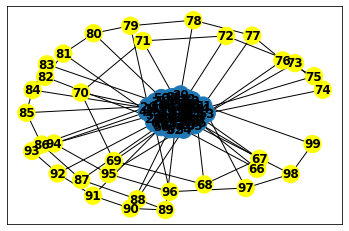

In [41]:
# Creating toy graph for demonstration

import networkx as nx
import random

tot = 100
split = int(tot/3)*2
G = nx.Graph()
G.add_nodes_from([i for i in range(tot)])
attrs = {i:{'lcl':(True if i < split else False)} for i in range(tot)}
nx.set_node_attributes(G, attrs)
node_color = [('#1f78b4' if i < split else '#ffff00') for i in range(tot)]

for n in range(split):
    for m in range(split):
        G.add_edge(n,m)
for n in range(split,tot):
    G.add_edge(n,n-1)
    G.add_edge(n, random.randint(0,split))
#G.add_edge(0,split+1)

assort = nx.attribute_assortativity_coefficient(G, 'lcl')
print('assortativity:', assort)

nx.draw_networkx(G, with_labels=True, node_color=node_color, font_weight='bold')

In [42]:
# Calculate Std Deviation using jackknife method:
import math

print('Edges:', G.number_of_edges())
assort = nx.attribute_assortativity_coefficient(G, 'lcl')

std = 0
for (u,v) in G.edges():
    G2 = G.copy()
    G2.remove_edge(u,v)
    assort_i = nx.attribute_assortativity_coefficient(G2, 'lcl')
    std += (assort_i - assort)**2

print('Assort: {:.4}, std: {:.4}'.format(assort, math.sqrt(std)))

Edges: 2280
Assort: 0.6389, std: 0.05681


#### Monte Carlo Simulations
However, for a large enough graph, iterating through M subgraphs is expensive. As an alternative, we can simulate an ensemble of null models (based on the configuration model) and calculate the mean and standard deviation for their assortativity values. The Z score for the observed value can then be calculated as:

\begin{equation}\label{eq:z-score}
  Z = \frac{r_{observed}-r_{rand}}{\sigma(r_{rand})}
\end{equation}

and converted into a p-value.

In [10]:
import numpy
from scipy.stats import norm

# Simulate n_simulation configuration models of network G and calculate
# assortativity based on label attr_label.

# NOTE: config models may be undirected or otherwise not respect the 
# direction of node edges, needs further testing.

def monte_carlo_sim(G, attr_label, n_simulation, verbose=True):
    if verbose:
        print('Graph nodes: {}, edges: {}'.format(G.number_of_nodes(), G.number_of_edges()))
        
    # Creating parameters for configuration model:
    seq_lbl = [(G.degree(n[0]), n[1][attr_label]) for n in G.nodes(data=True)]
    seq = [x[0] for x in seq_lbl]
    labels = [x[1] for x in seq_lbl]
    index = [i for i in range(len(labels))]
    attrs = dict(zip(index, labels))

    # Generating configuration models:
    config_vals = []
    for i in range(n_simulation):
        if i%int(n_simulation/10) == 0 and verbose:
            print('{:.0f}% -- Generating graph {} of {}'.format(i/N_SIMULATIONS*100, i, N_SIMULATIONS))
        G2 = nx.configuration_model(seq, seed=i**i)
        nx.set_node_attributes(G2, attrs, name=attr_label)
        assort_coef = nx.attribute_assortativity_coefficient(G2, attr_label)
        config_vals.append(assort_coef)

    assort_coef = nx.attribute_assortativity_coefficient(G, attr_label)
    print('\nOriginal Network assortativity: {:.5f}'.format(assort_coef))
    
    config_mean = numpy.array(config_vals).mean()
    config_std = numpy.array(config_vals).std()
    print('\nConfig assort mean: {:.4f}'.format(config_mean))
    print('Config assort std: {:.4f}'.format(config_std))

    zscore = (assort_coef-config_mean)/config_std
    pval = norm.sf(abs(zscore))*2
    print('\nOriginal Network Z-Score: {:.4f}'.format(zscore))
    print('p-val:', pval)
    
    return {'assort_coef':assort_coef,
            'zscore':zscore, 
            'pval':pval,
            'config_mean':config_mean, 
            'config_std':config_std,
            'config_vals':config_vals}

In [20]:
import networkx as nx

DIR = './data/harvey_user_location/graph_objs/'
GEXF_FILE = 'network_data_HurricaneHarvey_v1.gexf'

LCL_PRF_LABEL = 'lcl_profile'
LCL_PRF_NULL_VAL = ''
N_SIMULATION = 100

G = nx.read_gexf(DIR + GEXF_FILE)
#Subset of graph with valid lcl_profile values
nodes = [
    node
    for node, data
    in G.nodes(data=True)
    if data.get(LCL_PRF_LABEL) != LCL_PRF_NULL_VAL
]
G = G.subgraph(nodes)

assort_dict = monte_carlo_sim(G, LCL_PRF_LABEL, N_SIMULATION)

Graph nodes: 21157, edges: 76938
Generating graph 0 of 100
Generating graph 10 of 100
Generating graph 20 of 100
Generating graph 30 of 100
Generating graph 40 of 100
Generating graph 50 of 100
Generating graph 60 of 100
Generating graph 70 of 100
Generating graph 80 of 100
Generating graph 90 of 100

Original Network assortativity: 0.62652

Config assort mean: -0.0005
Config assort std: 0.0034

Original Network Z-Score: 183.0374
p-val: 0.0


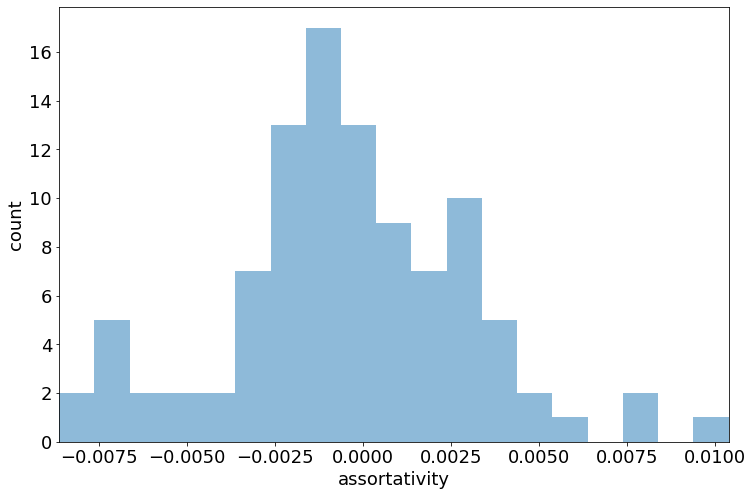

In [30]:
import numpy as np
# Import plt in opening cell of nb

LATEX_DIR = './data/harvey_user_location/latex/'

data = assort_dict['config_vals']

bins = np.linspace(min(data), max(data), 20) # fixed number of bins

plt.xlim([min(data), max(data)])

plt.hist(data, bins=bins, alpha=0.5)
#plt.title('Assortativity of Configuration Models')
plt.xlabel('assortativity')
plt.ylabel('count')

plt.savefig(LATEX_DIR + 'assort-monte-carlo-dist-hrv.png', bbox_inches='tight')
plt.show()

In [11]:
###
### Repeating simulation for Florence network
###

import networkx as nx

DIR = './data/florence_user_location/'
# LCC of users detected within first week of event:
GEXF_FILE = 'Florence_network_data_20210721.gexf'

LCL_PRF_LABEL = 'lcl_profile'
LCL_PRF_NULL_VAL = None

G = nx.read_gexf(DIR + GEXF_FILE)
#Subset of graph with valid lcl_profile values
nodes = [
    node
    for node, data
    in G.nodes(data=True)
    if data.get(LCL_PRF_LABEL) != LCL_PRF_NULL_VAL
]
G = G.subgraph(nodes)

assort_dict = monte_carlo_sim(G, LCL_PRF_LABEL, N_SIMULATION)

Graph nodes: 79807, edges: 2217826
Generating graph 0 of 100
Generating graph 10 of 100
Generating graph 20 of 100
Generating graph 30 of 100
Generating graph 40 of 100
Generating graph 50 of 100
Generating graph 60 of 100
Generating graph 70 of 100
Generating graph 80 of 100
Generating graph 90 of 100

Original Network assortativity: 0.54178

Config assort mean: -0.0001
Config assort std: 0.0007

Original Network Z-Score: 825.4337
p-val: 0.0


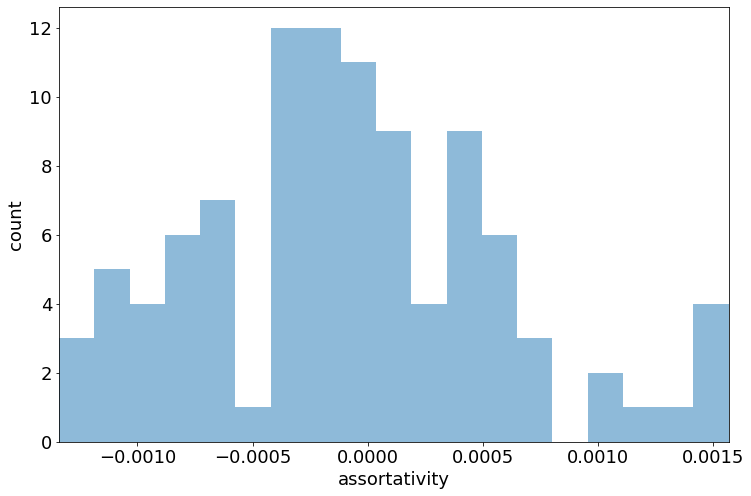

In [16]:
data = assort_dict['config_vals']

bins = np.linspace(min(data), max(data), 20) # fixed number of bins

plt.xlim([min(data), max(data)])

plt.hist(data, bins=bins, alpha=0.5)
#plt.title('Assortativity of Configuration Models')
plt.xlabel('assortativity')
plt.ylabel('count')

plt.savefig(LATEX_DIR + 'assort-monte-carlo-dist-flr.png', bbox_inches='tight')
plt.show()

In [19]:
set_tex_var('MCSimN', N_SIMULATION)

In [47]:
###
###
### TEMP TESTING MONTE CARLO SIM
###
###

assortativity: 0.7738277919863599


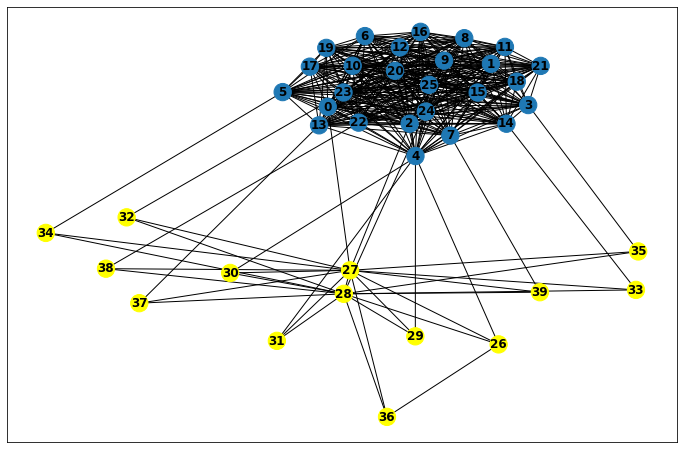

In [41]:
import networkx as nx
import random

tot = 40
split = int(tot/3)*2

G = nx.Graph()
G.add_nodes_from([i for i in range(tot)])

attrs = {i:{'lcl':(True if i < split else False)} for i in range(tot)}
nx.set_node_attributes(G, attrs)

for n in range(split):
    for m in range(split):
        G.add_edge(n,m)
for n in range(split,tot):
    G.add_edge(n,split+1)
    G.add_edge(n,split+2)
    G.add_edge(n, random.randint(0,split))
G.add_edge(0,split+1)


print('assortativity:', nx.attribute_assortativity_coefficient(G, 'lcl'))

node_color = [('#1f78b4' if i < split else '#ffff00') for i in range(tot)]
nx.draw_networkx(G, with_labels=True, node_color=node_color, font_weight='bold')

In [53]:
import numpy

N_SIMULATIONS = 10000

seq_lbl = [(G.degree(n[0]), n[1]['lcl']) for n in G.nodes(data=True)]
seq = [x[0] for x in seq_lbl]
labels = [x[1] for x in seq_lbl]
index = [i for i in range(len(labels))]
attrs = dict(zip(index, labels))

vals = []
for i in range(N_SIMULATIONS):
    if i%int(N_SIMULATIONS/10) == 0:
        print('{:.0f}% - {} of {}'.format(i/N_SIMULATIONS*100, i, N_SIMULATIONS))
    G2 = nx.configuration_model(seq, seed=i**i)
    nx.set_node_attributes(G2, attrs, name='lcl')
    assort_coef = nx.attribute_assortativity_coefficient(G2, 'lcl')
    vals.append(assort_coef)
   
print('\n')
print('Config assort mean:', numpy.array(vals).mean())
print('Config assort std:', numpy.array(vals).std())

#node_color = [('#1f78b4' if i < 10 else '#ffff00') for i in attrs.keys()]
#nx.draw_networkx(G2, with_labels=True, node_color=node_color, font_weight='bold')

0% - 0 of 10000
10% - 1000 of 10000
20% - 2000 of 10000
30% - 3000 of 10000
40% - 4000 of 10000
50% - 5000 of 10000
60% - 6000 of 10000
70% - 7000 of 10000
80% - 8000 of 10000
90% - 9000 of 10000


Config assort mean: -0.007900598733420517
Config assort std: 0.04849160656035515


In [46]:
# import json

# TEMP_FILENAME = './data/harvey_user_location/latex/temp_data.json'

# with open(TEMP_FILENAME, 'w') as outfile:
#     json.dump(vals, outfile)

In [47]:
# import json

# TEMP_FILENAME = './data/harvey_user_location/latex/temp_data.json'

# with open(TEMP_FILENAME) as json_file:
#     vals = json.load(json_file)

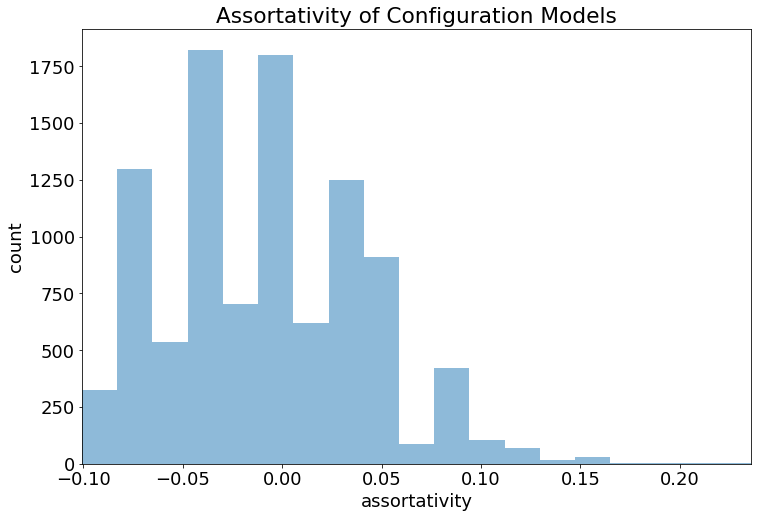

In [48]:
import numpy as np
from matplotlib import pyplot as plt

bins = np.linspace(min(vals), 
                   max(vals),
                   20) # fixed number of bins

plt.xlim([min(vals), max(vals)])

plt.hist(vals, bins=bins, alpha=0.5)
plt.title('Assortativity of Configuration Models')
plt.xlabel('assortativity')
plt.ylabel('count')

plt.show()

## Community Detection
In this section, a suite of community detection algorithms are run on the graph objects. The strength of community partitions is then measured using assortativity. The resulting community structures are then evaluated for their correlation with the locality label to determine whether community structure provides predictive value for user locality.

In [1]:
# Modularity:   https://scholar.google.com/scholar?q=Finding+community+structure+in+very+large+networks
# Label Prop:   https://neo4j.com/docs/graph-algorithms/current/algorithms/label-propagation/#algorithms-label-propagation-sample
# Louvain:      https://github.com/taynaud/python-louvain/blob/master/docs/index.rst

from networkx.algorithms.community import (greedy_modularity_communities, 
                                            label_propagation_communities, 
                                            asyn_lpa_communities, 
                                            asyn_fluidc, girvan_newman)
import community as community_louvain
from collections import Counter
import time

def calc_community_metrics(G):
    ''' 
    Returns a graph object enhanced with various community 
    metrics added as node attributes.
    
    Notes:
    - If return_lcc=True, the returned graph is undirected.
    - algorithms runs on LCC regardless of return_lcc value
    '''
    print('Calculating community metrics for graph. {} nodes and {} edges...'
              .format(len(G), G.number_of_edges()))

    # Create undirected LCC graph (required for some community detection algorithms):
    H = nx.Graph(G)
    H0 = get_giant_component(H)
    
#     print('Calculating c_modularity...')
#     start = time.time()
#     c_modularity = list(greedy_modularity_communities(H0))
#     print('Finished in {:.2f} seconds'.format(time.time()-start))
    
    print('Calculating c_label_prop...')
    start = time.time()
    c_label_prop = list(label_propagation_communities(H0))
    c_label_prop = sorted(c_label_prop, key=len, reverse=True)
    print('Finished in {:.2f} seconds'.format(time.time()-start))
    
    print('Calculating c_label_prop_asyn...')
    start = time.time()
    c_label_prop_asyn = list(asyn_lpa_communities(H0))
    c_label_prop_asyn = sorted(c_label_prop_asyn, key=len, reverse=True)
    print('Finished in {:.2f} seconds'.format(time.time()-start))
    
    # TOO SLOW:
    # print('Calculating c_girvan_newman...')
    # c_girvan_newman = list(girvan_newman(H0))
    
    print('Calculating c_louvain...')
    start = time.time()
    partition = community_louvain.best_partition(H0)
    # Rank indices by size
    counter = Counter(partition.values())
    ranking = sorted(counter, key=counter.get, reverse=True)
    partition_sorted = {k: ranking.index(v) for k, v in partition.items()}
    print('Finished in {:.2f} seconds'.format(time.time()-start))
    
    # Set fluid_community_number to the average of the values determined by the other algorithms
#     fluid_community_number = round(sum([len(x) for x in [c_modularity, c_label_prop, c_label_prop_asyn, counter]]) / 4)
    # Set fluid_community_number to the same as greedy_modularity
#    fluid_community_number = len(c_modularity)
    fluid_community_number = len(counter) # Number of Louvain communities
    print('Calculating c_fluid...')
    start = time.time()
    c_fluid = list(asyn_fluidc(H0, fluid_community_number))
    c_fluid = sorted(c_fluid, key=len, reverse=True)
    print('Finished in {:.2f} seconds'.format(time.time()-start))
    

    print('Adding data as node attributes...')
    community_output_dict = {
                            #'c_greedy_modularity': c_modularity,
                            'c_label_propogation': c_label_prop,
                            'c_label_prop_asyn': c_label_prop_asyn,
                            'c_fluid': c_fluid,
                            # 'c_girvan_newman': c_girvan_newman
                            }
    for key in community_output_dict:
        community_dict = {}
        for i, c in enumerate(community_output_dict[key]):
            for name in c:
                community_dict[name] = i
        nx.set_node_attributes(G, community_dict, key)
    # (Louvain package returns a different format):
    nx.set_node_attributes(G, partition_sorted, 'c_louvain_method')

    return G


def get_giant_component(G):
    ''' Returns largest connected component of graph '''
    Gcc = max(nx.connected_components(G), key=len)
    orig_nodes = len(G)
    orig_edges = G.number_of_edges()
    G = G.subgraph(Gcc)
    #G0 = nx.connected_component_subgraphs(H)[0]
    print('Largest component contains {} nodes ({:.1f}%) and {} edges ({:.1f}%).'
              .format(len(G), len(G)/orig_nodes*100, G.number_of_edges(), G.number_of_edges()/orig_edges*100))
    return G

In [2]:
# # Calculate the assortativity coeffficient
# # Reference: Newman, M. (2018). Networks. p211
# # Adapted from https://networkx.github.io/documentation/stable/_modules/networkx/algorithms/community/quality.html

# # Appears to return the same value as nx.attribute_assortativity_coefficient(G, col)

# from itertools import product
# from networkx.algorithms.community.community_utils import is_partition

# def assortativity_coef(G, communities, weight='weight'):
#     if not isinstance(communities, list):
#         communities = list(communities)
#     if not is_partition(G, communities):
#         raise Exception("Not a partition")
#     if G.is_directed():
#         raise Exception("Directed not supported")
#     if G.is_multigraph():
#         raise Exception("Multigraphs not yet supported")

#     m = G.size(weight=weight)

#     out_degree = dict(G.degree(weight=weight))
#     in_degree = out_degree # Redundant as only undirected supported
#     norm = 1 / (2 * m)

#     def val(u, v):
#         try:
#             w = G[u][v].get(weight, 1)
#         except KeyError:
#             w = 0
#         # Double count self-loops if the graph is undirected.
#         #if u == v:
#         #    w *= 2
#         return w - in_degree[u] * out_degree[v] * norm

#     def val2(u, v):
#         return in_degree[u] * out_degree[v] * norm

#     Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))

#     Qmax = ((2*m) - sum(val2(u, v) for c in communities for u, v in product(c, repeat=2)))

#     return Q, (Q / Qmax)

               

# def get_assort(G, label_name, label_values=None):
#     # Note: labels is a 2d array to support merging labels by providing arg label_values.
#     if not label_values:
#         label_values = [[x] for x in set(nx.get_node_attributes(G, label_name).values())]
#     partition = []
#     for label in label_values:
#         community = [node for node, data in G.nodes(data=True) if data.get(label_name) in label]
#         partition.append(community)
#     Q, assort_value = assortativity_coef(G, partition)
#     return Q, assort_value

# def get_comm_sizes(G, label_name, label_values=None):
#     # Note: labels is a 2d array to support merging labels by providing arg label_values.
#     # Note: Returned dict converts label names to str if any labels are merged
#     if not label_values:
#         label_values = [[x] for x in set(nx.get_node_attributes(G, label_name).values())]
#     has_merged_labels = max([len(x) for x in label_values]) > 1
#     d_len = {}
#     for label in label_values:
#         # Handle case where label arr contains multiple vals
#         if has_merged_labels:
#             label = [str(x) for x in label]
#             label_key = '-'.join(label)
#         else:
#             label_key = label[0]
#         d_len[label_key] = len([node for node, data in G.nodes(data=True) if data.get(label_name) in label])
#     return d_len

# # Simpler method without merging support
# # def get_comm_sizes(G, label_name):
# #     label_values = [[x] for x in set(nx.get_node_attributes(G, label_name).values())]
# #     d_len = {}
# #     for label in label_values:
# #         d_len[label_str] = len([node for node, data in G.nodes(data=True) if data.get(label_name) == label])
# #     return d_len

In [3]:
# Generate and export DF to Latex
import pandas as pd

def get_comm_summary_df(G):
    nodes = G.nodes(data=True)
    df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
    nodes = None
    #df_comm = df_comm[['c_modularity', 'c_label_prop', 'c_label_prop_asyn', 'c_fluid', 'c_louvain']]
    #df_comm = df_comm.reset_index(drop=True)
    comm_titles = [x for x in df_comm.columns if x[:2] == "c_"]

    summary_dict = {}
    for col in comm_titles:
        s = df_comm[col]
        n_comm = s.value_counts().size
        min_comm = s.value_counts().min()
        max_comm = s.value_counts().max()
    #     vals = get_comm_sizes(G, col).values()
    #     n_comm = len(vals)
    #     min_comm = min(vals)
    #     max_comm = max(vals)
        assort_coef = nx.attribute_assortativity_coefficient(G, col)
        #Q, assort_coef = get_assort(G, col)
        summary_dict[col[2:]] = [col[2:], assort_coef, n_comm, max_comm, min_comm]

    cols = ["Algorithm", "Assortativity Coefficient", "Number of Communities (C)", "Largest C", "Smallest C"]
    comm_summary_df = pd.DataFrame.from_dict(summary_dict, orient='index', columns=cols)
    return(comm_summary_df)


def generate_config_model(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    Gc = nx.configuration_model(degree_sequence)
    # Remove parallel edges and self loops:
    Gc = nx.Graph(Gc)
    #Gc.remove_edges_from(Gc.selfloop_edges())
    return(Gc)

In [4]:
N_SIMULATIONS = 10

'''
Run community detection on N_SIMULATIONS
configuration models based on G and return
average values as DataFrame.
'''
def calc_config_assort(G, n_simulations = 10):
    for i in range(n_simulations):
        print('\nRunning config model {}...'.format(i+1))
        G_config = generate_config_model(G)
        G_config = get_giant_component(G_config)
        G_config = calc_community_metrics(G_config)

        config_assort = get_comm_summary_df(G_config)["Assortativity Coefficient"]

        if i == 0:
            config_assort_avg = config_assort
        else:
            config_assort_avg += config_assort

    config_assort_avg = config_assort_avg/n_simulations
    return config_assort_avg

In [5]:
import networkx as nx

DIR = './data/harvey_user_location/graph_objs/'
GEXF_FILE = 'network_data_HurricaneHarvey_v1.gexf'

G = nx.read_gexf(DIR + GEXF_FILE)

##### Random G for testing:
# G = nx.karate_club_graph()
###############

# Values already recorded to G file, no need to recalculate:
#G = calc_community_metrics(G)
#nx.write_gexf(G, DIR + GEXF_FILE, prettyprint=True)

comm_summary_df = get_comm_summary_df(G)

Calculating community metrics for graph. 31932 nodes and 101096 edges...
Largest component contains 18410 nodes (57.7%) and 76341 edges (99.2%).
Calculating c_label_prop...
Finished in 23.92 seconds
Calculating c_label_prop_asyn...
Finished in 23.55 seconds
Calculating c_louvain...
Finished in 12.04 seconds
Calculating c_fluid...
Finished in 9.53 seconds
Adding data as node attributes...


In [6]:
config_assort_avg = calc_config_assort(G, N_SIMULATIONS)

comm_summary_df.insert(loc=2, column="Avg. Configuration Model Assortativity", value=config_assort_avg)
comm_summary_df


Running config model 1...
Largest component contains 19358 nodes (60.6%) and 100582 edges (100.0%).
Calculating community metrics for graph. 19358 nodes and 100582 edges...
Largest component contains 19358 nodes (100.0%) and 100582 edges (100.0%).
Calculating c_label_prop...
Finished in 6.61 seconds
Calculating c_label_prop_asyn...
Finished in 4.88 seconds
Calculating c_louvain...
Finished in 18.87 seconds
Calculating c_fluid...
Finished in 4.84 seconds
Adding data as node attributes...

Running config model 2...
Largest component contains 19370 nodes (60.7%) and 100541 edges (100.0%).
Calculating community metrics for graph. 19370 nodes and 100541 edges...
Largest component contains 19370 nodes (100.0%) and 100541 edges (100.0%).
Calculating c_label_prop...
Finished in 6.87 seconds
Calculating c_label_prop_asyn...
Finished in 6.09 seconds
Calculating c_louvain...
Finished in 16.14 seconds
Calculating c_fluid...
Finished in 5.82 seconds
Adding data as node attributes...

Running confi

,Algorithm,Assortativity Coefficient,Avg. Configuration Model Assortativity,Number of Communities (C),Largest C,Smallest C
label_propogation,label_propogation,0.701359,0.595737,1619,6383,2
label_prop_asyn,label_prop_asyn,0.718331,0.196005,1852,5851,2
fluid,fluid,0.500232,0.228420,82,441,140
louvain_method,louvain_method,0.742096,0.290944,82,3466,3


In [9]:
# Write DF to tex:

dec_dict = {"Assortativity Coefficient":2, "Avg. Configuration Model Assortativity":2}

df_to_tex(comm_summary_df, label='hrv-comm-detection', 
          caption='Community Detection for Harvey Network', 
          width=1, dec_dict=dec_dict)

Writing df to file as tex...


In [10]:
import networkx as nx

DIR = './data/florence_user_location/'
# LCC of users detected within first week of event:
GEXF_FILE = 'Florence_network_data_20210721.gexf'

G = nx.read_gexf(DIR + GEXF_FILE)
# Values already recorded to G file, no need to recalculate:
#G = calc_community_metrics(G)
#nx.write_gexf(G, DIR + GEXF_FILE, prettyprint=True)

comm_summary_df = get_comm_summary_df(G)

comm_summary_df

,Algorithm,Assortativity Coefficient,Number of Communities (C),Largest C,Smallest C
label_propogation,label_propogation,0.874124,858,87952,2
label_prop_asyn,label_prop_asyn,0.876300,932,85491,2
fluid,fluid,0.638628,35,7477,1767
louvain_method,louvain_method,0.745402,35,18497,3


In [12]:
config_assort_avg = calc_config_assort(G, N_SIMULATIONS)
comm_summary_df.insert(loc=2, column="Avg. Configuration Model Assortativity", value=config_assort_avg)

In [13]:
df_to_tex(comm_summary_df, label='flr-comm-detection', 
          caption='Community Detection for Florence Network', 
          width=1, dec_dict=dec_dict)

Writing df to file as tex...


In [14]:
# Convert int to str for latex export:
def int_to_str(x: int, capitalized=False):
    strings = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
    if x >= 10 or x < 0:
        return x
    elif capitalized:
        return strings[x].capitalize()
    else:
        return strings[x]

set_tex_var('commAlgCount', int_to_str(comm_summary_df.shape[0]))
set_tex_var('commConfigCount', int_to_str(N_SIMULATIONS))

## Comparing Community and Locality

Compare community labels with locality (as determined using gmaps API in prior notebook).

First, the proportion of local nodes in each community are visualised and compared to the expected value, then chi-square tests formally verify the correlation between the labels. note that this is expected given the establishment of assortative mixing in earlier sections and the understanding that community detection algorithms follow the same link-based structure.

### Harvey

In [154]:
import networkx as nx
import pandas as pd

DIR = './data/harvey_user_location/graph_objs/'
GEXF_FILE = 'network_data_HurricaneHarvey_v1.gexf'

G = nx.read_gexf(DIR + GEXF_FILE)

nodes = G.nodes(data=True)
df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
nodes = None

df_comm.head()

,screen_name,user_class,user_code,lcl_profile,label,c_label_propogation,c_label_prop_asyn,c_fluid,c_louvain_method
1000161164,edmesaaz,2,,,1000161164,NaN,NaN,NaN,NaN
100039898,SwiiFFtAyala,2,,,100039898,NaN,NaN,NaN,NaN
1000520550,TheGlenBird,2,,,1000520550,NaN,NaN,NaN,NaN
1000636034,1oakmoma,2,,false,1000636034,0.0,0.0,44.0,7.0
1000653007,ShansPLM,2,,false,1000653007,NaN,NaN,NaN,NaN


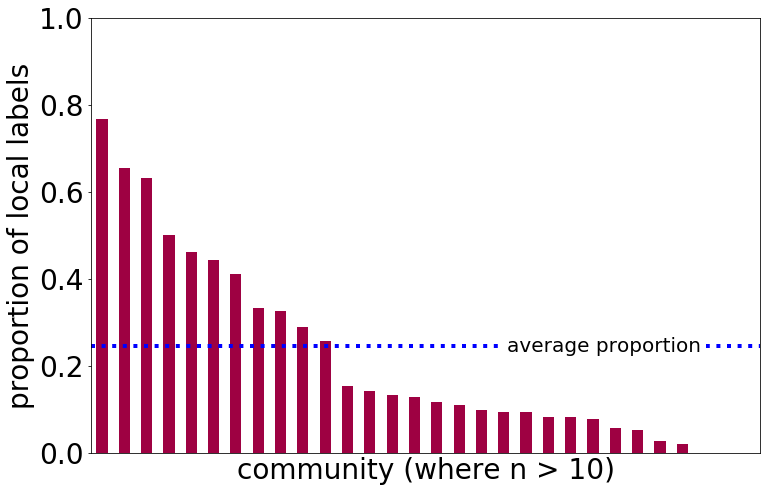

In [156]:
col = 'c_louvain_method'

s_lcl = df_comm.loc[df_comm['lcl_profile']=='true', col].value_counts()
s_total = df_comm.loc[df_comm['lcl_profile']!='', col].value_counts()
#s_total = df_comm[col].dropna().value_counts()

s_prop = s_lcl/s_total
s_prop = s_prop.fillna(0).sort_values(ascending=False)
s_prop = s_prop.loc[s_total > 10] # Only where community size > 10

ax = plt.axes()
exp_pos_proportion = df_comm.loc[df_comm['lcl_profile']=='true'].shape[0] / df_comm.loc[df_comm['lcl_profile']!=''].shape[0]
ax.axhline(y=exp_pos_proportion, color='b', linestyle='dotted', lw=4)

s_prop.plot(kind='bar', colormap='Spectral', ax=ax)
plt.xticks([])
plt.xlabel('community (where n > 10)')
plt.ylabel('proportion of local labels')

plt.ylim([0, 1])
plt.text(len(s_prop)*.75, exp_pos_proportion, 'average proportion', fontsize=20, va='center', ha='center', backgroundcolor='w')
#plt.legend()

#print(len(s_prop))

plt.savefig(LATEX_DIR + 'comm-lcl-prop-hrv.png', bbox_inches='tight')

In [16]:
# #from sklearn.feature_selection import chi2
# import pandas as pd
# import numpy as np
# from scipy.stats import chi2_contingency
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline

# X = df_comm['c_louvain_method']
# y = df_comm['lcl_profile']

# contigency = pd.crosstab(X, y)
# contigency = pd.crosstab(X, y, normalize='index')

# # plt.figure(figsize=(12,8)) 
# # sns.heatmap(contigency, annot=True, cmap="YlGnBu")

In [58]:
from scipy.stats import chi2_contingency

nodes = G.nodes(data=True)
df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
nodes = None

for col in df_comm.columns:
    if not col[:2] == 'c_':
        continue

    # Exclude communities below a certain size:
    counts = df_comm[col].value_counts()
    comms = counts[counts > 10].index
    X = df_comm[df_comm[col].isin(comms)][col]

    #X = df_comm[col]
    y = df_comm['lcl_profile']

    # Drop nan lcl_profile vals:
    #X = X.loc[y != '']
    y = y.loc[y != '']

    contigency = pd.crosstab(X, y, normalize='index')

    # Chi-square test of independence. 
    c, p, dof, expected = chi2_contingency(contigency)
    print('{:.4f} {}'.format(p, col))

# Null hypothesis = variables are independent. > 0.95, so reject the null

0.99955510977633 c_label_propogation
0.9999291391964272 c_label_prop_asyn
0.9999999999913572 c_fluid
0.9999830157647027 c_louvain_method


### Florence

In [143]:
import networkx as nx
import pandas as pd

DIR = './data/florence_user_location/'
GEXF_FILE = 'Florence_network_data_20210721.gexf'
G = nx.read_gexf(DIR + GEXF_FILE)

nodes = G.nodes(data=True)
df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
nodes = None

df_comm.head()

,screen_name,user_class,user_id,ratio_original,ratio_detected,ratio_media,tweets_per_hour,top_source,lcl_profile,c_label_propogation,c_label_prop_asyn,c_fluid,c_louvain_method,label
1000013516147916800,SummerLoving31,2,1000013516147916800,1.000000,1.0,0.000000,0.005952,Twitter Lite,False,0,0,14,6,1000013516147916800
1000014475,FlipEdwards71,2,1000014475,0.153846,1.0,0.000000,0.077381,Twitter for Android,NaN,1,2,0,7,1000014475
1000034146251608065,teamtropicstorm,2,1000034146251608065,1.000000,1.0,0.666667,0.017857,IFTTT,False,0,0,2,0,1000034146251608065
1000046340557156353,FKosgalwies,2,1000046340557156353,1.000000,1.0,0.000000,0.005952,Twitter Web Client,NaN,0,0,26,1,1000046340557156353
1000073973336608768,Timthegamer12,2,1000073973336608768,0.000000,1.0,0.000000,0.005952,Twitter for Android,NaN,0,0,16,4,1000073973336608768


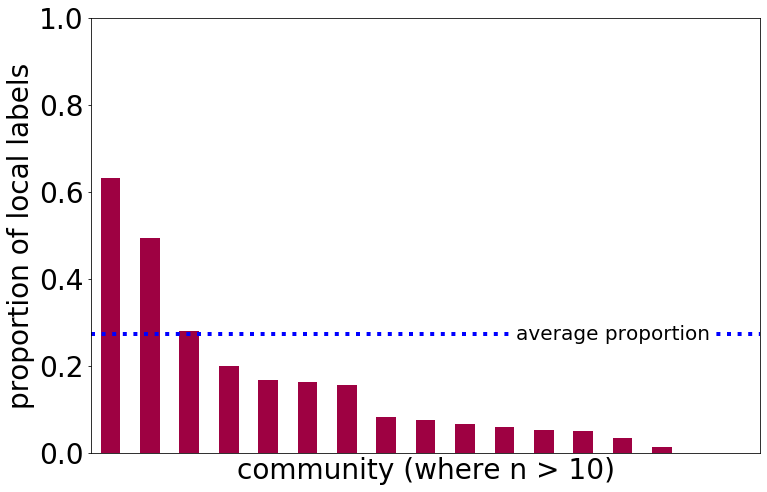

In [153]:
col = 'c_louvain_method'

s_lcl = df_comm.loc[df_comm['lcl_profile']==True, col].value_counts()
s_total = df_comm.loc[df_comm['lcl_profile'] != None, col].value_counts()
#s_total = df_comm[col].dropna().value_counts()

s_prop = s_lcl/s_total
s_prop = s_prop.fillna(0).sort_values(ascending=False)
s_prop = s_prop.loc[s_total > 10] # Only where community size > 10

ax = plt.axes()
exp_pos_proportion = sum(df_comm['lcl_profile'] == True) / sum(df_comm['lcl_profile'].isna() == False)
ax.axhline(y=exp_pos_proportion, color='b', linestyle='dotted', lw=4)

s_prop.plot(kind='bar', colormap='Spectral', ax=ax)
plt.xticks([])
plt.xlabel('community (where n > 10)')
plt.ylabel('proportion of local labels')

plt.ylim([0, 1])
plt.text(len(s_prop)*.75, exp_pos_proportion, 'average proportion', fontsize=20, va='center', ha='center', backgroundcolor='w')

plt.savefig(LATEX_DIR + 'comm-lcl-prop-flr.png', bbox_inches='tight')

In [129]:
from scipy.stats import chi2_contingency

nodes = G.nodes(data=True)
df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
nodes = None

for col in df_comm.columns:
    if not col[:2] == 'c_':
        continue

    # Exclude communities below a certain size:
    counts = df_comm[col].value_counts()
    comms = counts[counts > 10].index
    X = df_comm[df_comm[col].isin(comms)][col]

    #X = df_comm[col]
    y = df_comm['lcl_profile']

    # Drop nan lcl_profile vals:
    #X = X.loc[y != '']
    y = y.loc[y != '']

    contigency = pd.crosstab(X, y, normalize='index')

    # Chi-square test of independence. 
    c, p, dof, expected = chi2_contingency(contigency) 
    print('{:.4f} {}'.format(p, col))

# Null hypothesis = variables are independent. > 0.95, so reject the null

0.9993 c_label_propogation
0.9983 c_label_prop_asyn
0.9999 c_fluid
0.9953 c_louvain_method


## Evaluating Community Metrics

Test communities to see whether more local communities are, for example, more connected. Visual results show little correlation, so this was not pursued.

In [99]:
import networkx as nx
import pandas as pd

DIR = './data/harvey_user_location/graph_objs/'
GEXF_FILE = 'network_data_HurricaneHarvey_v1.gexf'

# DIR = './data/florence_user_location/'
# GEXF_FILE = 'Florence_network_data_20210721.gexf'

G = nx.read_gexf(DIR + GEXF_FILE)

nodes = G.nodes(data=True)
df = pd.DataFrame.from_dict(dict(nodes), orient='index')
nodes = None

algorithms = [col for col in df.columns if col[:2] == 'c_']

df.head()

,screen_name,user_class,user_id,ratio_original,ratio_detected,ratio_media,tweets_per_hour,top_source,lcl_profile,c_label_propogation,c_label_prop_asyn,c_fluid,c_louvain_method,label
1000013516147916800,SummerLoving31,2,1000013516147916800,1.000000,1.0,0.000000,0.005952,Twitter Lite,False,0,0,14,6,1000013516147916800
1000014475,FlipEdwards71,2,1000014475,0.153846,1.0,0.000000,0.077381,Twitter for Android,NaN,1,2,0,7,1000014475
1000034146251608065,teamtropicstorm,2,1000034146251608065,1.000000,1.0,0.666667,0.017857,IFTTT,False,0,0,2,0,1000034146251608065
1000046340557156353,FKosgalwies,2,1000046340557156353,1.000000,1.0,0.000000,0.005952,Twitter Web Client,NaN,0,0,26,1,1000046340557156353
1000073973336608768,Timthegamer12,2,1000073973336608768,0.000000,1.0,0.000000,0.005952,Twitter for Android,NaN,0,0,16,4,1000073973336608768


In [104]:
from networkx.algorithms.cluster import average_clustering
from networkx.algorithms.assortativity import degree_assortativity_coefficient

MIN_COMM_SIZE = 20

# for algorithm in algorithms:
algorithm = 'c_louvain_method'

counts = df[algorithm].value_counts()
communities = counts[counts > MIN_COMM_SIZE].index

comm_dict = {}

for comm in communities:
    comm_nodes = [node for node, data in G.nodes(data=True) if data.get(algorithm) == comm]
    G_s = G.subgraph(comm_nodes)
    
    # Make undirected
    G_s = nx.Graph(G_s)
    
    df_s = df.loc[df.index.isin(comm_nodes)]
    lcl_prop = len(df_s.loc[df_s['lcl_profile']=='true']) / len(df_s.loc[df_s['lcl_profile']!=''])
#     lcl_prop = sum(df_s['lcl_profile'] == True) / sum(df_s['lcl_profile'].isna() == False)
    
    cent_deg = nx.degree_centrality(G_s)
    cent_deg = sum(cent_deg.values())/len(cent_deg)
    cent_eigen = nx.eigenvector_centrality(G_s, max_iter=10000)
    cent_eigen = sum(cent_eigen.values())/len(cent_eigen)
    
#     cent_bet = nx.betweenness_centrality(G_s)
#     cent_bet = sum(cent_bet.values())/len(cent_bet)
    
#     cent_close = nx.closeness_centrality(G_s)
#     cent_close = sum(cent_close.values())/len(cent_close)
    
    assort_deg = degree_assortativity_coefficient(G_s)
    
    clustering = average_clustering(G_s)
    
    avg_deg = 2*G_s.number_of_edges() / float(G_s.number_of_nodes())
    
    comm_dict[comm] = {'size': len(comm_nodes), 'lcl_prop': lcl_prop, 'avg_cent_deg':cent_deg, 'avg_cent_eigen':cent_eigen,
#                       'cent_bet':cent_bet, 'cent_close':cent_close, 
                       'assort_deg':assort_deg, 'clustering':clustering, 'avg_deg':avg_deg}

/home/rosles/projects/crisis-data/venv/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ae806b8d0>,
      dtype=object)

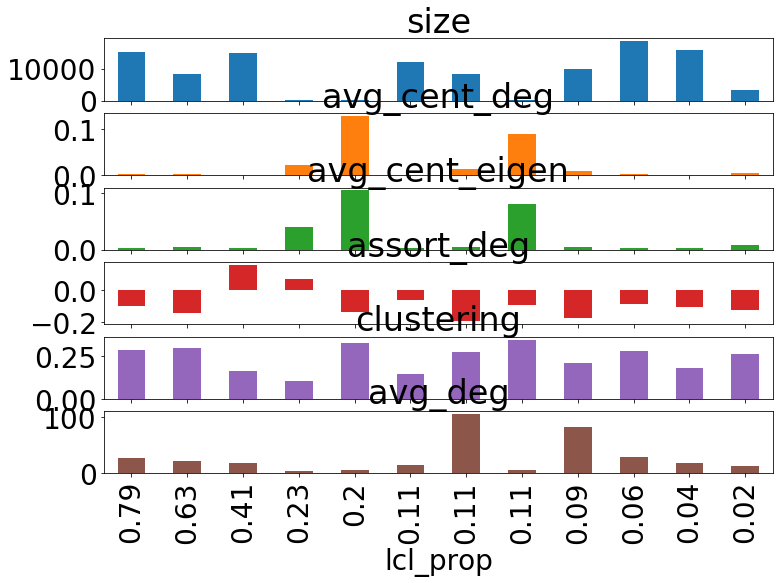

In [107]:
Plot the values calculated above, sorted by prdf_test = pd.DataFrame.from_dict(comm_dict, orient='index')

df_test = df_test.loc[df_test['size'] > 50]
df_test['lcl_prop'] = df_test['lcl_prop'].round(2)

df_test = df_test.sort_values('lcl_prop', ascending=False)
df_test[['size', 'lcl_prop', 'avg_cent_deg', 'avg_cent_eigen', 
#          'cent_bet', 'cent_close',
        'assort_deg', 'clustering', 'avg_deg']].plot(kind='bar', subplots=True, legend=False, x='lcl_prop')


In [106]:
df_test

,size,lcl_prop,avg_cent_deg,avg_cent_eigen,assort_deg,clustering,avg_deg
2,15293,0.79,0.001814,0.003386,-0.098411,0.289913,27.741581
6,8369,0.63,0.002635,0.004156,-0.144611,0.296457,22.051380
3,14872,0.41,0.001205,0.002317,0.157292,0.164696,17.924825
9,191,0.23,0.022320,0.039521,0.067464,0.107110,4.240838
11,51,0.20,0.129412,0.105153,-0.139667,0.326895,6.470588
4,12203,0.11,0.001256,0.003342,-0.065003,0.148255,15.323117
7,8350,0.11,0.012578,0.005533,-0.195935,0.278286,105.014132
10,60,0.11,0.090960,0.081354,-0.094485,0.348961,5.366667
5,9769,0.09,0.008432,0.004798,-0.175894,0.212176,82.362575
0,18497,0.06,0.001516,0.002421,-0.088228,0.282140,28.048440


## Classification